In [207]:
import pandas as pd

import numpy as np

import datetime

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools

import sys
sys.path.insert(0, '../code')
from functions import *

import datetime as dt

from dateutil.relativedelta import relativedelta

%matplotlib inline

In [12]:
df_1 = pd.read_csv("../data/Zip_zhvi_bdrmcnt_1_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv")
df_2 = pd.read_csv("../data/Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv")


In [13]:
df_1 = df_1[df_1.CountyName == 'San Francisco County']
df_2 = df_2[df_2.CountyName == 'San Francisco County']

----------------------------------------------------------------------

How to melt a dataframe

In [14]:
df_1_melt = melt_data(df_1)
df_2_melt = melt_data(df_2)
columns = ['RegionID', 'date', 'value']
df_1 = df_1_melt[columns]
df_2 = df_2_melt[columns]

In [78]:
df_1[df_1.RegionID==97557].drop('RegionID', axis = 1)

,date,value
6,1996-01-31,247368.0
31,1996-02-29,247287.0
56,1996-03-31,245709.0
81,1996-04-30,244646.0
106,1996-05-31,243029.0
...,...,...
7431,2020-10-31,773197.0
7456,2020-11-30,767661.0
7481,2020-12-31,755610.0
7506,2021-01-31,745923.0


In [22]:
df_1.iloc[0,]

RegionID                  97564
date        1996-01-31 00:00:00
value                    260256
Name: 0, dtype: object

--------------------------------------------------------

-----------------------------------------------------------

In [25]:
sf_1_all = df_1.groupby('date').aggregate({'value':'mean'})
sf_2_all = df_2.groupby('date').aggregate({'value':'mean'})

<ipython-input-28-bce1502b89cb>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(sf_1_all, freq=12 )


<Figure size 432x288 with 0 Axes>

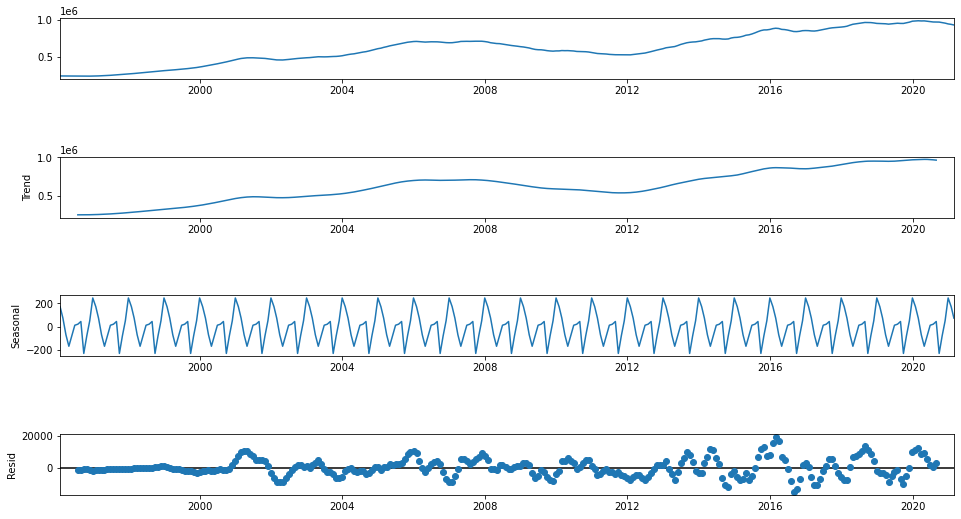

<Figure size 432x288 with 0 Axes>

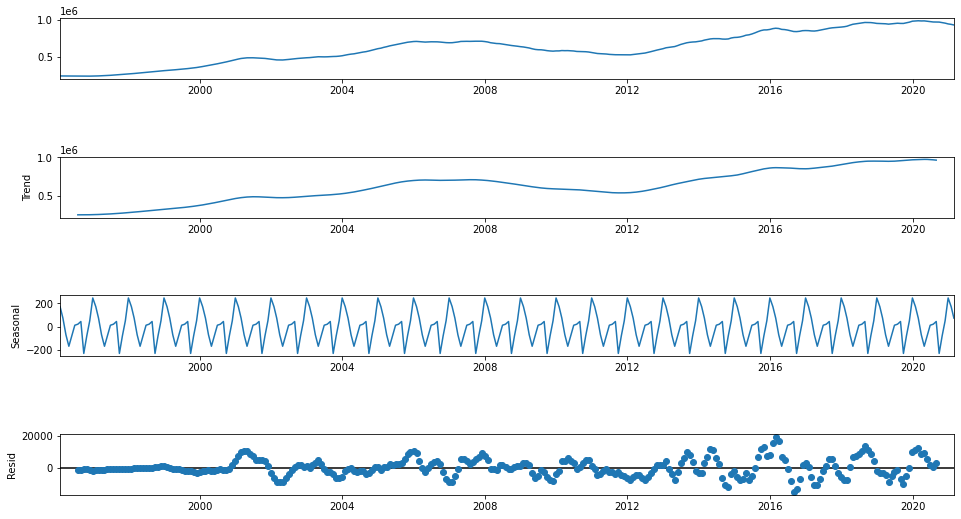

In [28]:
for i in [sf_1_all,sf_2_all]:
    decomposition = seasonal_decompose(sf_1_all, freq=12 )
    fig = plt.figure()
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)

------------------------------------------------------

dictionary of dataframes for each zip code

---------------------------------------------------

In [326]:
ids = list(set(df_1.RegionID))

keys = [i for i in list(map(str,ids))]

sf_df_list= []

for i in ids:
    
    sf_df_list.append(df_1[df_1.RegionID == i])
    
    sf_df_list[-1].drop('RegionID', inplace = True, axis = 1)
    
    sf_df_list[-1].date = pd.to_datetime(sf_df_list[-1].date)
    
    sf_df_list[-1].set_index('date', inplace = True)
    
    sf_df_list[-1] = sf_df_list[-1].asfreq('M')
    
    
    
sf_dict = dict(zip(keys,sf_df_list))

/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

In [327]:
sf_dict.pop('97610')

sf_dict.pop('97559')

,value
date,
2001-12-31,479474.0
2002-01-31,484416.0
2002-02-28,486941.0
2002-03-31,494619.0
2002-04-30,503433.0
...,...
2020-10-31,924403.0
2020-11-30,918924.0
2020-12-31,906665.0


----------------------------------------------

# Train-test split

-----------------------

In [252]:
cutoff = round(len(sf_dict[list(sf_dict.keys())[0]])*.8)

sf_train_dict_list = [sf_dict[i][:cutoff] for i in list(sf_dict.keys())]

sf_train_dict = dict(zip(list(sf_dict.keys()), sf_train_dict_list))

sf_test_dict_list = [sf_dict[i][cutoff:] for i in list(sf_dict.keys())]

sf_test_dict = dict(zip(list(sf_dict.keys()), sf_test_dict_list))

In [86]:
sf_train_dict

{'97557':                value
 date                
 1996-01-31  247368.0
 1996-02-29  247287.0
 1996-03-31  245709.0
 1996-04-30  244646.0
 1996-05-31  243029.0
 ...              ...
 2015-10-31  757172.0
 2015-11-30  758796.0
 2015-12-31  764042.0
 2016-01-31  773676.0
 2016-02-29  779693.0
 
 [242 rows x 1 columns],
 '97558':                value
 date                
 1996-01-31  235924.0
 1996-02-29  234289.0
 1996-03-31  231853.0
 1996-04-30  228146.0
 1996-05-31  224543.0
 ...              ...
 2015-10-31  853537.0
 2015-11-30  853645.0
 2015-12-31  856899.0
 2016-01-31  863295.0
 2016-02-29  865576.0
 
 [242 rows x 1 columns],
 '97559':                value
 date                
 2001-12-31  479474.0
 2002-01-31  484416.0
 2002-02-28  486941.0
 2002-03-31  494619.0
 2002-04-30  503433.0
 ...              ...
 2020-10-31  924403.0
 2020-11-30  918924.0
 2020-12-31  906665.0
 2021-01-31  897307.0
 2021-02-28  887025.0
 
 [231 rows x 1 columns],
 '97560':                value
 da

--------------

parameters for sarimax grid search

-----------

In [36]:
pdq = [(2, 1, 0),(2, 1, 1)]

In [37]:
seasonal_pdq = [(1, 1, 0, 12),(1, 1, 1, 12),(2, 1, 0, 12),(2, 1, 1, 12)]

In [40]:
zipcodes = []
param_list = []
param_seasonal_list = []
aic_list = []


#for train in [sf_train_dict[i] for i in list(sf_train_dict.keys())]:

for zipcode, train in sf_train_dict.items():
    
    for param in pdq:
        
        for param_seasonal in seasonal_pdq:
            

                mod=SARIMAX(train.dropna(),
                             order=param,
                             seasonal_order=param_seasonal,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
                zipcodes.append(zipcode)
                param_list.append(param)
                param_seasonal_list.append(param_seasonal)
                aic_list.append(mod.fit().aic)
                print(aic_list[-1])
           

4198.186949839617
4199.425421736016
3941.707856944706
3942.9324087381538
4200.724642660024
4201.804610135687
3943.492800363407
3945.0773601372603
4148.437869316155
4148.504991262714
3851.6305930502213
3852.7936761189376
4147.227759380967
4147.011663493203
3886.7152868545013


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3888.928041030037
4116.074843971501
4118.022772287771
3808.088090008006
3850.853414069491
4114.486973012344
4119.566393399907
3848.722875049274
3847.930713643528
4214.130095293146
4214.514832658607
3908.7551768060357
3947.733142153898
4216.768289640651
4214.9131275134005
3947.958425476493
3949.57174134264
4169.070294508883
4169.758116074068
3869.816229155625
3912.9087079323276
4161.666967451811
4162.39612391111
3900.8706974117263
3901.7626810514057
4204.937459509609
4206.253414992785
3945.3360308744004
3946.71724051592
4201.45337758166


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4202.81462223624
3943.995831259329


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3955.878391100947
4178.238487231652
4178.882033114021
3921.7790001990134
3923.1080062620276
4178.937010668889
4178.225803185101


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3922.0004651873596


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3923.7357302772157
4227.838310303067
4227.15195485959
3967.330211961667
3968.495734107041
4229.359428030772
4228.42602715454
3968.2677696238725
3969.4864309613977
4321.088538451393
4320.112376936083
4042.2366807195476
4043.155703002905
4319.05789493148
4318.218687317531
4040.427506323453
4041.2440659593485
4181.576463619684
4180.768710444447
3918.7442705517624
3919.632274536654


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4166.731885350748
4176.248060398225
3913.78138393173


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3916.7125557566264
4268.406257072692
4268.982899808425
3979.2081160775874
4008.72952913274
4270.0455080459105
4270.459694772209
4009.3898842980834
4009.790439442285
4204.643591847075
4215.781735450867
3945.950430727958
3947.2252069277624
4215.834398222019
4215.323937625716
3942.7420886452815
3943.899824448443
4201.715829259609
4202.115099552291
3929.5009442096098
3930.6371073414466
4203.009746371458
4203.392681348069
3930.187846324563
3931.256081716966
4205.8033024058395
4206.619304857695
3950.7360621948233
3914.3633787388344
4207.151719122403
4207.7424749895345
3951.413063875535
3951.0798291794313
4223.9024408151645
4222.283651402664
3948.048916794685
3949.531037453852
4225.493976139276
4223.8460197265995
3949.3091452102194
3951.0807608946743
4250.985961936041
4247.914016925112
3973.8461241766804
3928.8236219855626
4249.709328605919
4249.173691294002
3971.683352428612
3972.9524745097488
4250.560615099239
4250.5545782079935
3938.611150344983
3978.9232764846356
4239.288977762642
4251.45

/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3801.1995203700485
3818.9942437314644
4333.582074909033
4335.2118898406925
4065.6711173596805
4067.3645344898982
4332.499811735255
4333.6631459872615
4063.379396379925
4068.678223976634
4181.8586075318935
4182.828027234313
3917.875334569281
3918.3342749581434
4184.739184486172
4185.277363759388
3918.724351452963
3919.012232644681
4061.80633567688
4060.977091814115
3772.847724698331
3771.2480193355386
4063.155566513348
4061.8531165317454


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3774.575145933619


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3800.8988274734556
4248.229467524085
4247.4769260873945
3950.7484629617643
3984.714945949626
4249.102387388775
4248.372564848082
3984.8175628805084
3986.0229200649196
4111.609061142181
4090.6865106347846
3834.910204502524
3833.246121809494
4109.427083788651
4113.027239210669


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3845.3325943561063


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3855.461940067951
2650.300557009739
2671.9341564385186
2369.174473589723
2411.5945556395
2669.70972989036
2671.2676989225884


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2409.0854592681862
2412.515401608352


In [41]:
data = {'zipcodes' : zipcodes,
        'param': param_list,
        'param_seasonal': param_seasonal_list,
        'aic': aic_list}


sf_sarimax_details_df = pd.DataFrame(data)


sf_sarimax_details_df.shape

(200, 4)

In [42]:
sf_sarimax_details_df

,zipcodes,param,param_seasonal,aic
0,sf_cheese_df_97557,"(2, 1, 0)","(1, 1, 0, 12)",4198.186950
1,sf_cheese_df_97557,"(2, 1, 0)","(1, 1, 1, 12)",4199.425422
2,sf_cheese_df_97557,"(2, 1, 0)","(2, 1, 0, 12)",3941.707857
3,sf_cheese_df_97557,"(2, 1, 0)","(2, 1, 1, 12)",3942.932409
4,sf_cheese_df_97557,"(2, 1, 1)","(1, 1, 0, 12)",4200.724643
...,...,...,...,...
195,sf_cheese_df_97610,"(2, 1, 0)","(2, 1, 1, 12)",2411.594556
196,sf_cheese_df_97610,"(2, 1, 1)","(1, 1, 0, 12)",2669.709730
197,sf_cheese_df_97610,"(2, 1, 1)","(1, 1, 1, 12)",2671.267699
198,sf_cheese_df_97610,"(2, 1, 1)","(2, 1, 0, 12)",2409.085459


In [43]:
sf_sarimax_details_df.loc[sf_sarimax_details_df.groupby("zipcodes")["aic"].idxmin()]

,zipcodes,param,param_seasonal,aic
2,sf_cheese_df_97557,"(2, 1, 0)","(2, 1, 0, 12)",3941.707857
10,sf_cheese_df_97558,"(2, 1, 0)","(2, 1, 0, 12)",3851.630593
18,sf_cheese_df_97559,"(2, 1, 0)","(2, 1, 0, 12)",3808.088090
26,sf_cheese_df_97560,"(2, 1, 0)","(2, 1, 0, 12)",3908.755177
34,sf_cheese_df_97562,"(2, 1, 0)","(2, 1, 0, 12)",3869.816229
46,sf_cheese_df_97563,"(2, 1, 1)","(2, 1, 0, 12)",3943.995831
50,sf_cheese_df_97564,"(2, 1, 0)","(2, 1, 0, 12)",3921.779000
58,sf_cheese_df_97565,"(2, 1, 0)","(2, 1, 0, 12)",3967.330212
70,sf_cheese_df_97566,"(2, 1, 1)","(2, 1, 0, 12)",4040.427506
78,sf_cheese_df_97567,"(2, 1, 1)","(2, 1, 0, 12)",3913.781384


In [45]:
sf_sarimax_details_df['zipcodes']= [i[-5:] for i in sf_sarimax_details_df.zipcodes]

In [47]:
sf_best_df = sf_sarimax_details_df.loc[sf_sarimax_details_df.groupby("zipcodes")["aic"].idxmin()]
sf_best_df.set_index('zipcodes', inplace = True)

--------------------------------------------------------------------------------

In [67]:
sf_best_df.loc['97610'].param

(2, 1, 0)

In [69]:
sf_best_df.loc['97610'].param_seasonal

(2, 1, 0, 12)

In [83]:
sf_best_df.head(1)

,param,param_seasonal,aic
zipcodes,,,
97557,"(2, 1, 0)","(2, 1, 0, 12)",3941.707857


In [97]:
sf_test_dict['97557'].index

DatetimeIndex(['2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30',
               '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31', '2018-01-31', '2018-02-28',
               '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
               '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28',
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29',
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
      

In [111]:
sf_test_dict
sf_test_dict['97557'].index[-1]

Timestamp('2021-02-28 00:00:00', freq='M')

In [221]:
sf_train_dict

{'97557':                value
 date                
 1996-01-31  247368.0
 1996-02-29  247287.0
 1996-03-31  245709.0
 1996-04-30  244646.0
 1996-05-31  243029.0
 ...              ...
 2015-10-31  757172.0
 2015-11-30  758796.0
 2015-12-31  764042.0
 2016-01-31  773676.0
 2016-02-29  779693.0
 
 [242 rows x 1 columns],
 '97558':                value
 date                
 1996-01-31  235924.0
 1996-02-29  234289.0
 1996-03-31  231853.0
 1996-04-30  228146.0
 1996-05-31  224543.0
 ...              ...
 2015-10-31  853537.0
 2015-11-30  853645.0
 2015-12-31  856899.0
 2016-01-31  863295.0
 2016-02-29  865576.0
 
 [242 rows x 1 columns],
 '97559':                value
 date                
 2001-12-31  479474.0
 2002-01-31  484416.0
 2002-02-28  486941.0
 2002-03-31  494619.0
 2002-04-30  503433.0
 ...              ...
 2020-10-31  924403.0
 2020-11-30  918924.0
 2020-12-31  906665.0
 2021-01-31  897307.0
 2021-02-28  887025.0
 
 [231 rows x 1 columns],
 '97560':                value
 da

In [227]:
sf_test_dict['97557'].index[:-12]

DatetimeIndex(['2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30',
               '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31', '2018-01-31', '2018-02-28',
               '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
               '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28',
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29'],
              dtype='datetime64[ns]', name='date', freq='M')

# Forecast

In [259]:
sf_train_dict['97610'].index[-1] >= pd.to_datetime('2021-02-28')

#Timestamp('2017-02-28 00:00:00')

False

In [328]:



cutoff = round(len(sf_dict[list(sf_dict.keys())[0]])*.8)

sf_train_dict_list = [sf_dict[i][:cutoff] for i in list(sf_dict.keys())]

sf_train_dict = dict(zip(list(sf_dict.keys()), sf_train_dict_list))

sf_test_dict_list = [sf_dict[i][cutoff:] for i in list(sf_dict.keys())]

sf_test_dict = dict(zip(list(sf_dict.keys()), sf_test_dict_list))





sf_predict_dict = {}

for _ in range(5):

    for zipcode, df in sf_train_dict.items():

        if sf_train_dict[zipcode].index[-1] >= pd.to_datetime('2021-02-28'):
            
            continue
        
        sari_mod = SARIMAX(df,

                           order=sf_best_df.loc[zipcode].param,

                           seasonal_order=sf_best_df.loc[zipcode].param_seasonal,

                           enforce_stationarity=False,

                           enforce_invertibility=False).fit()

#         end = date + relativedelta(years=+1)
#         end = dt.datetime(
#             end.year, (end + relativedelta(months=1)).month, 1) - dt.timedelta(days=1)

#         end = pd.to_datetime(end)

#         predict = sari_mod.predict(
#             # start='2016-03-31', dynamic=False, end = '2021-02-28', typ='levels')
#             start=date, dynamic=False, end=end, typ='levels')

        predict = sari_mod.forecast(steps = 12, dynamic = False)
    
        print((zipcode,predict.index[-1],predict[-1]))

        sf_predict_dict[zipcode] = predict

        dfB = pd.DataFrame(sf_predict_dict[zipcode])

        dfB.columns = ['value']

        dfA = sf_train_dict[zipcode]

        sf_train_dict[zipcode] = pd.concat([dfA, dfB], axis=0)

('97557', Timestamp('2017-02-28 00:00:00', freq='M'), 816928.5620225283)
('97558', Timestamp('2017-02-28 00:00:00', freq='M'), 916202.8786931335)
('97560', Timestamp('2017-02-28 00:00:00', freq='M'), 996503.079671154)
('97562', Timestamp('2017-02-28 00:00:00', freq='M'), 968694.7695592702)
('97563', Timestamp('2017-02-28 00:00:00', freq='M'), 873100.5689794465)
('97564', Timestamp('2017-02-28 00:00:00', freq='M'), 922214.5163172381)
('97565', Timestamp('2017-02-28 00:00:00', freq='M'), 1060612.1138752813)
('97566', Timestamp('2017-02-28 00:00:00', freq='M'), 1108924.3885379313)
('97567', Timestamp('2017-02-28 00:00:00', freq='M'), 861921.5020447832)
('97568', Timestamp('2017-02-28 00:00:00', freq='M'), 1065840.795997542)
('97569', Timestamp('2017-02-28 00:00:00', freq='M'), 973740.9065181748)
('97570', Timestamp('2017-02-28 00:00:00', freq='M'), 1094167.9706871947)
('97571', Timestamp('2017-02-28 00:00:00', freq='M'), 941287.4255061977)
('97572', Timestamp('2017-02-28 00:00:00', freq='

/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


('97563', Timestamp('2018-02-28 00:00:00', freq='M'), 935221.8174936161)
('97564', Timestamp('2018-02-28 00:00:00', freq='M'), 985371.3578427447)
('97565', Timestamp('2018-02-28 00:00:00', freq='M'), 1155137.3246707246)
('97566', Timestamp('2018-02-28 00:00:00', freq='M'), 1181091.5802811533)
('97567', Timestamp('2018-02-28 00:00:00', freq='M'), 932846.9376464447)
('97568', Timestamp('2018-02-28 00:00:00', freq='M'), 1154143.695947196)
('97569', Timestamp('2018-02-28 00:00:00', freq='M'), 1030285.5041291884)
('97570', Timestamp('2018-02-28 00:00:00', freq='M'), 1195426.9788643338)
('97571', Timestamp('2018-02-28 00:00:00', freq='M'), 1011245.4834959864)
('97572', Timestamp('2018-02-28 00:00:00', freq='M'), 890339.0089268623)
('97575', Timestamp('2018-02-28 00:00:00', freq='M'), 945654.4217263001)
('97576', Timestamp('2018-02-28 00:00:00', freq='M'), 1115890.9531745762)
('97577', Timestamp('2018-02-28 00:00:00', freq='M'), 1100973.0346581903)
('97578', Timestamp('2018-02-28 00:00:00', f

/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


('97581', Timestamp('2018-02-28 00:00:00', freq='M'), 1473504.8443130886)
('97585', Timestamp('2018-02-28 00:00:00', freq='M'), 866538.371854352)
('97586', Timestamp('2018-02-28 00:00:00', freq='M'), 804822.8987918878)
('97587', Timestamp('2018-02-28 00:00:00', freq='M'), 1026070.7780619297)
('97588', Timestamp('2018-02-28 00:00:00', freq='M'), 865508.6574902938)
('97557', Timestamp('2019-02-28 00:00:00', freq='M'), 946970.5715251472)
('97558', Timestamp('2019-02-28 00:00:00', freq='M'), 1052492.4835670055)
('97560', Timestamp('2019-02-28 00:00:00', freq='M'), 1134218.1401688883)
('97562', Timestamp('2019-02-28 00:00:00', freq='M'), 1131779.50871405)


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


('97563', Timestamp('2019-02-28 00:00:00', freq='M'), 1011162.2773726333)
('97564', Timestamp('2019-02-28 00:00:00', freq='M'), 1074349.4441070678)
('97565', Timestamp('2019-02-28 00:00:00', freq='M'), 1244669.1034874355)
('97566', Timestamp('2019-02-28 00:00:00', freq='M'), 1298344.2919183027)
('97567', Timestamp('2019-02-28 00:00:00', freq='M'), 1035953.5984214512)
('97568', Timestamp('2019-02-28 00:00:00', freq='M'), 1264834.9946239672)
('97569', Timestamp('2019-02-28 00:00:00', freq='M'), 1131826.6154169547)
('97570', Timestamp('2019-02-28 00:00:00', freq='M'), 1347377.6279838963)
('97571', Timestamp('2019-02-28 00:00:00', freq='M'), 1095477.5730866133)
('97572', Timestamp('2019-02-28 00:00:00', freq='M'), 978549.111836075)
('97575', Timestamp('2019-02-28 00:00:00', freq='M'), 1026740.7726196975)
('97576', Timestamp('2019-02-28 00:00:00', freq='M'), 1217846.915209005)
('97577', Timestamp('2019-02-28 00:00:00', freq='M'), 1192621.8864019113)
('97578', Timestamp('2019-02-28 00:00:00'

/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


('97581', Timestamp('2019-02-28 00:00:00', freq='M'), 1619231.9348990726)
('97585', Timestamp('2019-02-28 00:00:00', freq='M'), 948011.6599446282)
('97586', Timestamp('2019-02-28 00:00:00', freq='M'), 912514.3210896868)
('97587', Timestamp('2019-02-28 00:00:00', freq='M'), 1114999.8650926382)
('97588', Timestamp('2019-02-28 00:00:00', freq='M'), 945828.3847533613)
('97557', Timestamp('2020-02-29 00:00:00', freq='M'), 991789.3256573762)
('97558', Timestamp('2020-02-29 00:00:00', freq='M'), 1104545.3721969025)
('97560', Timestamp('2020-02-29 00:00:00', freq='M'), 1188095.8424274733)
('97562', Timestamp('2020-02-29 00:00:00', freq='M'), 1184866.3576837305)
('97563', Timestamp('2020-02-29 00:00:00', freq='M'), 1066271.8842128497)
('97564', Timestamp('2020-02-29 00:00:00', freq='M'), 1130674.5593216945)
('97565', Timestamp('2020-02-29 00:00:00', freq='M'), 1310982.5309490727)
('97566', Timestamp('2020-02-29 00:00:00', freq='M'), 1384864.1306894447)
('97567', Timestamp('2020-02-29 00:00:00',

/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


('97569', Timestamp('2020-02-29 00:00:00', freq='M'), 1199875.259611829)
('97570', Timestamp('2020-02-29 00:00:00', freq='M'), 1427688.1669013011)
('97571', Timestamp('2020-02-29 00:00:00', freq='M'), 1152616.3429702832)
('97572', Timestamp('2020-02-29 00:00:00', freq='M'), 1009889.1300564747)
('97575', Timestamp('2020-02-29 00:00:00', freq='M'), 1084383.7848711603)
('97576', Timestamp('2020-02-29 00:00:00', freq='M'), 1270540.7943390745)
('97577', Timestamp('2020-02-29 00:00:00', freq='M'), 1261097.81052307)
('97578', Timestamp('2020-02-29 00:00:00', freq='M'), 822284.6634405007)
('97581', Timestamp('2020-02-29 00:00:00', freq='M'), 1730362.2499778226)
('97585', Timestamp('2020-02-29 00:00:00', freq='M'), 1008009.786408559)
('97586', Timestamp('2020-02-29 00:00:00', freq='M'), 987616.7000158268)
('97587', Timestamp('2020-02-29 00:00:00', freq='M'), 1182240.3116180494)
('97588', Timestamp('2020-02-29 00:00:00', freq='M'), 1020767.6227515582)
('97557', Timestamp('2021-02-28 00:00:00', f

/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


('97563', Timestamp('2021-02-28 00:00:00', freq='M'), 1134601.5462234048)
('97564', Timestamp('2021-02-28 00:00:00', freq='M'), 1207556.69103444)
('97565', Timestamp('2021-02-28 00:00:00', freq='M'), 1404825.8005775213)
('97566', Timestamp('2021-02-28 00:00:00', freq='M'), 1473996.1956925243)


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


('97567', Timestamp('2021-02-28 00:00:00', freq='M'), 1181046.9135663684)
('97568', Timestamp('2021-02-28 00:00:00', freq='M'), 1438239.9701407666)


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


('97569', Timestamp('2021-02-28 00:00:00', freq='M'), 1270603.1597349495)
('97570', Timestamp('2021-02-28 00:00:00', freq='M'), 1546701.0657535493)
('97571', Timestamp('2021-02-28 00:00:00', freq='M'), 1229172.7096352307)
('97572', Timestamp('2021-02-28 00:00:00', freq='M'), 1066244.788517465)
('97575', Timestamp('2021-02-28 00:00:00', freq='M'), 1154096.2015830385)
('97576', Timestamp('2021-02-28 00:00:00', freq='M'), 1367555.6717734525)
('97577', Timestamp('2021-02-28 00:00:00', freq='M'), 1315470.062359604)
('97578', Timestamp('2021-02-28 00:00:00', freq='M'), 891852.0560920766)
('97581', Timestamp('2021-02-28 00:00:00', freq='M'), 1859709.3230226536)
('97585', Timestamp('2021-02-28 00:00:00', freq='M'), 1077424.7673485465)
('97586', Timestamp('2021-02-28 00:00:00', freq='M'), 1068730.7299138764)
('97587', Timestamp('2021-02-28 00:00:00', freq='M'), 1241887.394521022)
('97588', Timestamp('2021-02-28 00:00:00', freq='M'), 1100026.5255775466)


In [313]:
from sklearn import metrics

RMSE = metrics.mean_squared_error(sf_test_dict['97588'],sf_train_dict['97588'].iloc[-60:])
RM

KeyError: '97588'

In [329]:
RMSE_list = []

for zipcode, df in sf_test_dict.items():
    RMSE = metrics.mean_squared_error(sf_test_dict[zipcode].dropna(),sf_train_dict[zipcode].iloc[-60:].dropna(), squared = False)
    RMSE_list.append(RMSE)

In [330]:
RMSE_list

[164536.70576040685,
 177819.6923486183,
 195738.31858085928,
 197938.8659271594,
 181240.70932901822,
 201663.84274835075,
 197300.46774067826,
 297981.2633628348,
 89129.00903379169,
 212304.29197493516,
 178324.96526477914,
 146064.52460585383,
 164887.82432425034,
 56204.79713541061,
 88623.51122190962,
 60414.038618928615,
 172197.25454153103,
 121778.79410402646,
 229339.3784823227,
 182148.24846643745,
 161122.7212358211,
 194751.77843027667,
 118873.74451892816]

-----------------------------------------------------------

----------------------

# NOT STEPWISE 


sf_forecast_dict = {}

for regionid, df in sf_dict.items():

    regionid = regionid[-5:]
    #df.plot()
    #plt.show()
    sari_mod = SARIMAX(df.dropna(),
                       
                       order=sf_best_df.loc[regionid].param,
                       
                       seasonal_order=sf_best_df.loc[regionid].param_seasonal,
                       
                       enforce_stationarity=False,
                       
                       enforce_invertibility=False).fit()
    
    forecast = sari_mod.forecast(steps=12)
    sf_forecast_dict[regionid] = forecast
    fig, ax = plt.subplots()
    ax.plot(df.index, df.value, label='Historical')
    ax.plot(forecast, label='Forecast')
    ax.set_title(
        f'San Francisco {regionid} Housing Prices 1 year out\n using SARIMAX(2, 1, 0)x(2, 1, 0, 12)')
    plt.legend()

In [170]:
sf_forecast_dict

{'97557': 2021-03-31    1.178978e+06
 2021-04-30    1.173008e+06
 2021-05-31    1.165721e+06
 2021-06-30    1.167593e+06
 2021-07-31    1.162613e+06
 2021-08-31    1.158323e+06
 2021-09-30    1.148807e+06
 2021-10-31    1.146076e+06
 2021-11-30    1.136113e+06
 2021-12-31    1.124874e+06
 2022-01-31    1.118999e+06
 2022-02-28    1.117291e+06
 Freq: M, Name: predicted_mean, dtype: float64,
 '97558': 2021-03-31    1.094153e+06
 2021-04-30    1.087257e+06
 2021-05-31    1.079236e+06
 2021-06-30    1.074314e+06
 2021-07-31    1.066560e+06
 2021-08-31    1.058359e+06
 2021-09-30    1.046562e+06
 2021-10-31    1.039767e+06
 2021-11-30    1.029471e+06
 2021-12-31    1.019844e+06
 2022-01-31    1.014639e+06
 2022-02-28    1.012911e+06
 Freq: M, Name: predicted_mean, dtype: float64,
 '97559': 2021-03-31    1.687642e+06
 2021-04-30    1.680127e+06
 2021-05-31    1.677121e+06
 2021-06-30    1.673006e+06
 2021-07-31    1.678266e+06
 2021-08-31    1.686999e+06
 2021-09-30    1.686869e+06
 2021-10-

In [193]:
table_dict = {'zipcode': list(sf_forecast_dict.keys()) ,
              'current_value': [df.iloc[-1].values[0] for df in list(sf_dict.values())] ,
              'forecasted_value': [df.iloc[-1] for df in list(sf_forecast_dict.values())]
             }

final_df = pd.DataFrame(table_dict)

In [196]:
final_df['percent_change'] = round(100*(final_df.forecasted_value - final_df.current_value )/final_df.current_value,2)

In [200]:
final_df.sort_values('percent_change', axis = 0, ascending=False)

,zipcode,current_value,forecasted_value,percent_change
15,97575,1443658.0,1.507369e+06,4.41
12,97570,1395930.0,1.438780e+06,3.07
23,97588,956182.0,9.848421e+05,3.00
16,97576,1439525.0,1.475448e+06,2.50
19,97581,1488832.0,1.520768e+06,2.15
14,97572,1421186.0,1.449162e+06,1.97
3,97560,1706714.0,1.738443e+06,1.86
9,97567,1137737.0,1.153425e+06,1.38
21,97586,1182842.0,1.191954e+06,0.77
7,97565,1398923.0,1.404549e+06,0.40
